In [1]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
import pickle
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

In [2]:
output_dir = Path.home() / 'Desktop' / 'disk2' / 'ecephys_data'
cache = EcephysProjectCache.from_warehouse(manifest=output_dir / 'manifest.json')
channel_df = cache.get_channels()
probes_df = cache.get_probes()

In [3]:
with open('VISpm_VISp_probes.pkl', 'rb') as f:
    probe_list = pickle.load(f)

probe_dict = {e[0]: [e[1], e[2]] for e in probe_list}    
print('{session_id: [VISpm/VISp_probe_1, VISpm/VISp_probe_2]}')
probe_dict

{session_id: [VISpm/VISp_probe_1, VISpm/VISp_probe_2]}


{719161530: [729445650, 729445652],
 732592105: [733744647, 733744649],
 754312389: [756781555, 756781557],
 750332458: [757904547, 757904550],
 751348571: [757984818, 757984820],
 737581020: [757988389, 757988391],
 756029989: [760640087, 760640090],
 755434585: [760642624, 760642628],
 761418226: [768908582, 768908585],
 742951821: [769322714, 769322716],
 759883607: [769322789, 769322793],
 750749662: [769322804, 769322806],
 760693773: [769322824, 769322827],
 758798717: [770930071, 770930073],
 767871931: [773462990, 773462993],
 771160300: [773621939, 773621942],
 771990200: [773654726, 773654728],
 778240327: [792607547, 792607549],
 786091066: [792623919, 792623921],
 778998620: [792626844, 792626847],
 779839471: [792645493, 792645497],
 791319847: [805008602, 805008604],
 797828357: [805579738, 805579741],
 760345702: [810753197, 810753199],
 715093703: [810755799, 810755801],
 794812542: [810758779, 810758781],
 821695405: [822645895, 822645897],
 831882777: [832810576, 8328

In [4]:
existing_sessions = []

for sid in probe_dict.keys():
    if os.path.isdir(output_dir/f'session_{sid}'):
        existing_sessions.append(sid)
existing_sessions

[719161530,
 732592105,
 754312389,
 750332458,
 751348571,
 737581020,
 756029989,
 755434585,
 761418226,
 742951821,
 759883607,
 750749662,
 760693773,
 758798717,
 791319847,
 797828357,
 760345702,
 715093703]

In [21]:
def gauss(x,mu,sigma,A):
    return A*np.exp(-(x-mu)**2/2/sigma**2)

def bimodal(x,mu1,sigma1,A1,mu2,sigma2,A2):
    return gauss(x,mu1,sigma1,A1)+gauss(x,mu2,sigma2,A2)

def get_bimodal_params_and_cutoff(x,y):
    f = bimodal
    params,cov=curve_fit(f,x,y,method='lm')
    
    mu1, sigma1, ampl1, mu2, sigma2, ampl2 = params
    
    print(f'mu1 = {mu1}\nsigma1 = {sigma1}\namplitude1 = {ampl1}\nmu2 = {mu2}\nsigma2 = {sigma2}\namplitude2 = {ampl2}\n')
    
    cutoff = (mu1 * sigma2**2 + mu2 * sigma1**2) / (sigma1**2 + sigma2**2)
    
    return (params,cutoff)



def run(session_id):
    print(f'SESSION ID = {session_id}')
    session = cache.get_session_data(session_id)
    
    stim_flashes = session.get_stimulus_table(['flashes'])
    
    running_speed_midpoints = session.running_speed["start_time"] + (session.running_speed["end_time"] - session.running_speed["start_time"]) / 2
    
    time_velocity_df = pd.concat([running_speed_midpoints, session.running_speed["velocity"]],axis=1,keys=['running_speed_midpoint','velocity'])
    
    fig, ax = plt.subplots(ncols=2,nrows=1,figsize=(10,5))
    
    # Computing the histogram of running speed
    running_velocity_hist = ax[0].hist(time_velocity_df.velocity,bins=300)
    ax[0].set_xlabel('velocity (cm/s)')

    # Extracting the x-y data from histogram and adjusting x values to middle of bins
    y,x,_ = running_velocity_hist
    x = x[:-1] # cut at the last value of x array
    x_bin_width = x[1]-x[0]
    x = x + (x_bin_width / 2)
    
    try:
        # Getting parameters and cutoff of fitted bimodal
        params,cutoff = get_bimodal_params_and_cutoff(x,y)
        mu1, sigma1, ampl1, mu2, sigma2, ampl2 = params

        fitted_y = bimodal(x,*params)
        
        print('cutoff =', cutoff)
    except:
        print('ERROR IN FITTING BIMODAL DISTRIBUTION')
    
    min_x_between_means = 0
    try:
        # Alternative cutoff value = x value corresponding to minimum y value in between two means of bimodal
        # min_y_between_means = fitted_y[np.where(np.logical_and(x > mu2, x < mu1))].min()
        min_y_between_means = fitted_y[np.where(np.logical_and(x > mu1, x < mu2))].min()
        min_x_between_means = x[np.where(fitted_y==min_y_between_means)][0]
        print('min_x_between_means =', min_x_between_means)

        # Plotting fitted bimodal and cutoff lines
        ax[0].plot(x,fitted_y,color='orange',lw=1.5)
        ax[0].axvline(cutoff,c='r',label=f'cutoff = {cutoff}')
        ax[0].axvline(min_x_between_means,c='g',label=f'min_x_between_means = {min_x_between_means}')

        ax[0].legend()

        ax[0].set_xlim([-50,100])
        
        ax[0].set_title('running velocity distribution')
    except:
        print('ERROR IN CALCULATING min_x_between_means')
    
    ax[1].plot(time_velocity_df.velocity)
    ax[1].set_xlim([stim_flashes.start_time.unique()[0],stim_flashes.start_time.unique()[-1]])
    ax[1].axhline(min_x_between_means,c='g',label=f'min_x_between_means = {min_x_between_means}')
    ax[1].set_title('running speed during flash presentation period')
    ax[1].legend()

    plt.tight_layout()

    plt.show()
    print('=============================================================================================================')
    return min_x_between_means, time_velocity_df.velocity, stim_flashes

SESSION ID = 719161530
mu1 = 0.3605942588387782
sigma1 = 2.181427710005213
amplitude1 = 132781.3767952978
mu2 = 31.815070781070737
sigma2 = -20.18936165783177
amplitude2 = 17001.111971636383

cutoff = 0.7235704632592312
min_x_between_means = 9.564384860472103


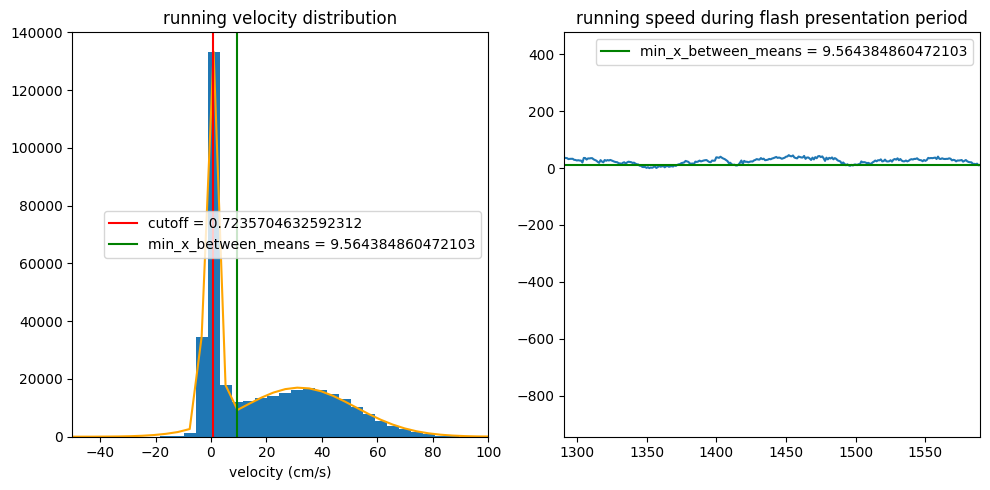

SESSION ID = 732592105
mu1 = 0.03076405798987515
sigma1 = 1.7999149463148663
amplitude1 = 104087.00471294776
mu2 = 33.26857484537639
sigma2 = 22.577718865925547
amplitude2 = 4890.574683350389

cutoff = 0.24067006562535925
min_x_between_means = 8.013263840973384


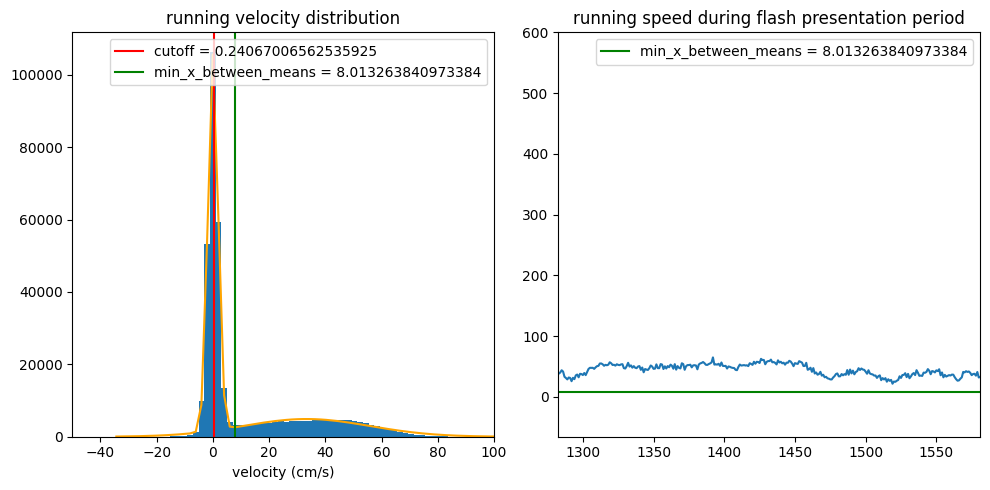

SESSION ID = 754312389
mu1 = 0.03919322873737636
sigma1 = 1.5720008201064797
amplitude1 = 23868.27293364781
mu2 = 8.473464900994385
sigma2 = 8.267983150224598
amplitude2 = 1147.5861773895801

cutoff = 0.3334533384545086
min_x_between_means = 6.1594843907271475


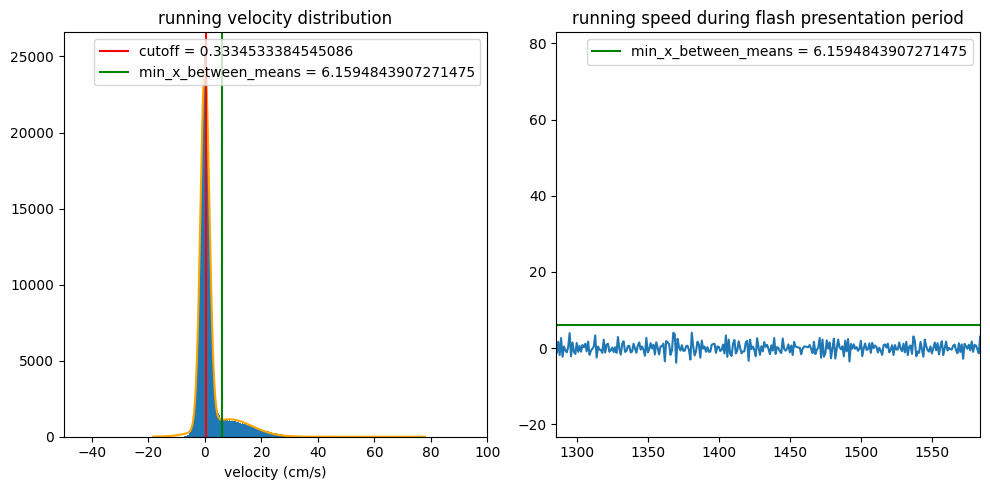

SESSION ID = 750332458
mu1 = 0.05714550324564438
sigma1 = 1.821220409845562
amplitude1 = 58117.44368205793
mu2 = 43.0401997278732
sigma2 = 29.555905171744776
amplitude2 = 2673.28223448947

cutoff = 0.21973327614484744
min_x_between_means = 7.909607857825851


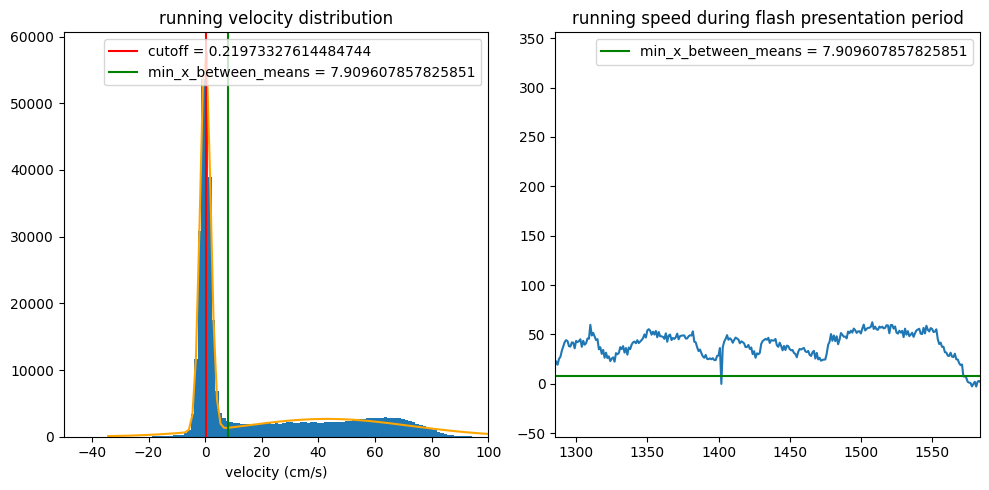

SESSION ID = 751348571
mu1 = 0.17965082164794577
sigma1 = 1.6653519781171087
amplitude1 = 37820.50463798393
mu2 = 9.968236548290026
sigma2 = 8.072776888581807
amplitude2 = 8378.056149108314

cutoff = 0.5792149687499798
min_x_between_means = 5.8126045088210105


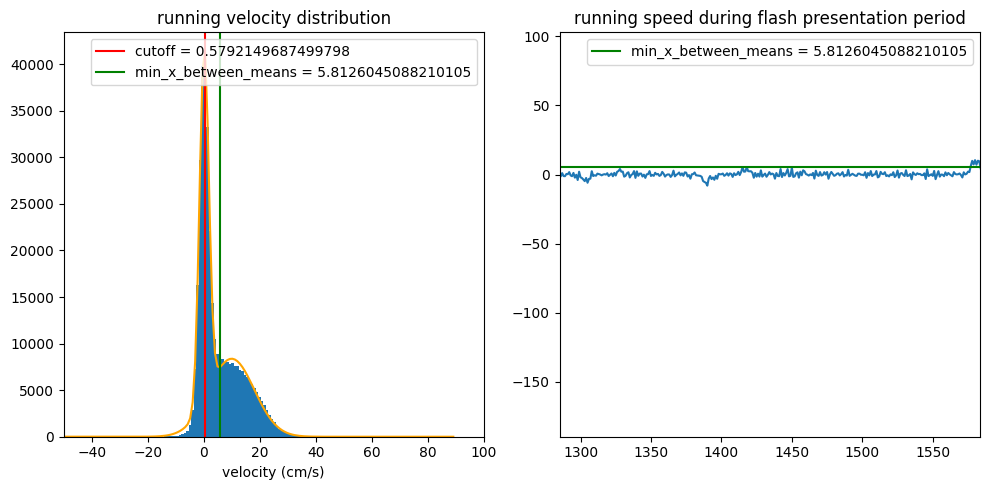

SESSION ID = 737581020
mu1 = 18.903131729028644
sigma1 = 21.32150224776763
amplitude1 = 10311.37700845672
mu2 = 18.90290817599164
sigma2 = 21.321337981631544
amplitude2 = 10311.378687588242

cutoff = 18.903019951648986
ERROR IN CALCULATING min_x_between_means


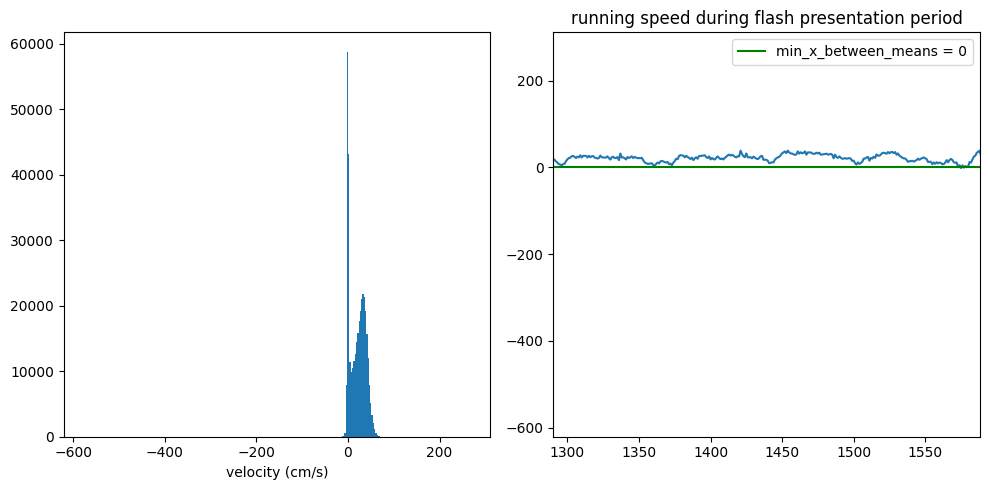

SESSION ID = 756029989
mu1 = 33.47680103467756
sigma1 = 23.62845903000673
amplitude1 = 9529.283968928185
mu2 = 0.04667227044112135
sigma2 = 1.8639970661611784
amplitude2 = 111503.45260465785

cutoff = 0.2534307533332132
ERROR IN CALCULATING min_x_between_means


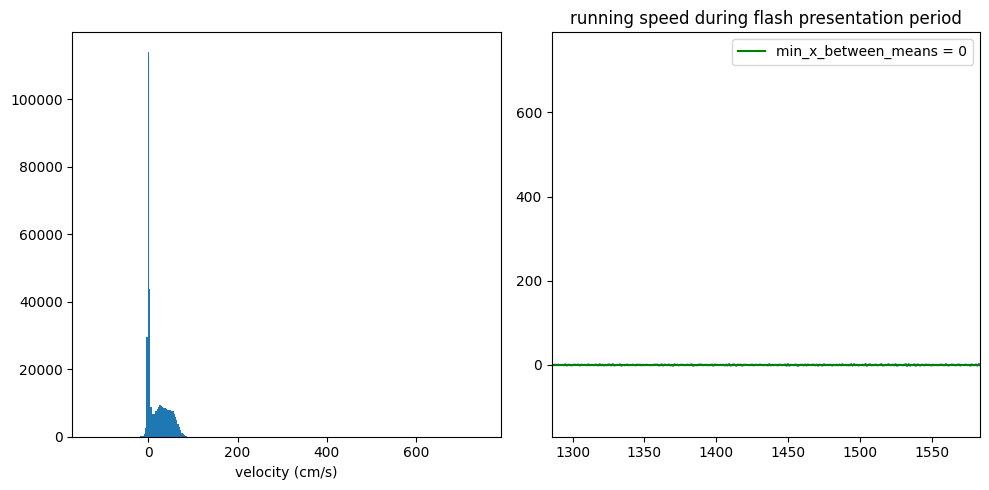

SESSION ID = 755434585
mu1 = 23.708972449223683
sigma1 = 22.300642041408
amplitude1 = 1175.8332197394907
mu2 = 0.04348834220409654
sigma2 = 1.6295704798148256
amplitude2 = 35868.14517162771

cutoff = 0.16918222790985513
ERROR IN CALCULATING min_x_between_means


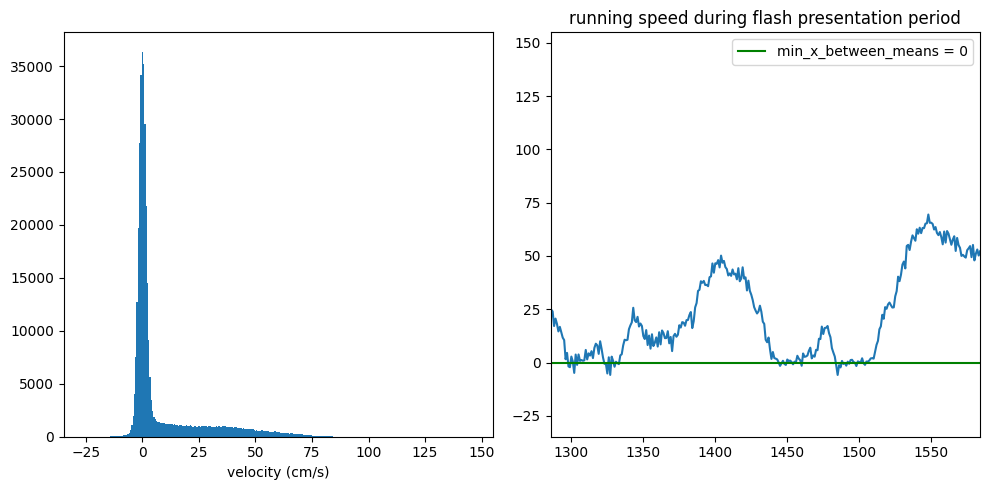

SESSION ID = 761418226
mu1 = 49.7481867912093
sigma1 = 21.433379263146975
amplitude1 = 9700.72455259199
mu2 = 0.0943265861701533
sigma2 = -1.8238737620240886
amplitude2 = 138408.72393832082

cutoff = 0.4512933692995657
ERROR IN CALCULATING min_x_between_means


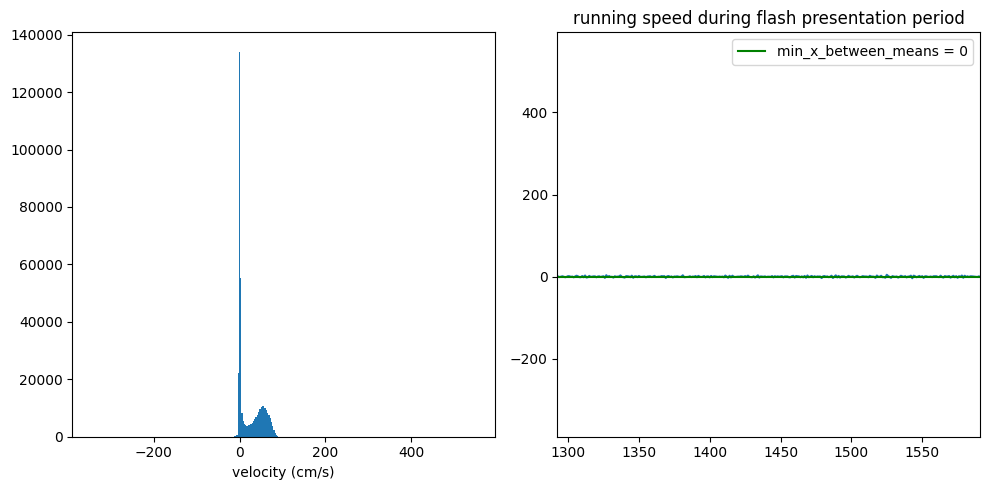

SESSION ID = 742951821
mu1 = 2.706047902819518
sigma1 = 4.031580314474214
amplitude1 = 647.2477562218314
mu2 = 0.011070296354758612
sigma2 = 1.4481831773259481
amplitude2 = 16033.848885345471

cutoff = 0.31906652295151805
ERROR IN CALCULATING min_x_between_means


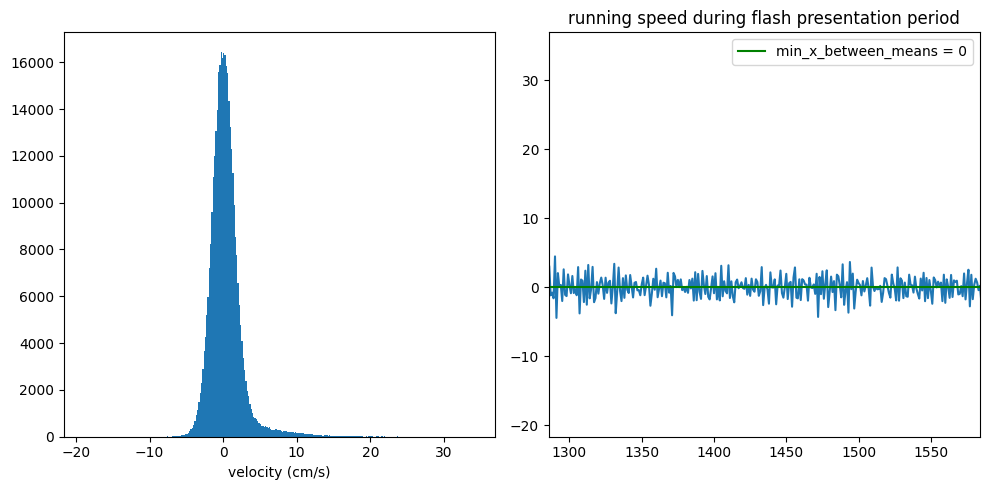

SESSION ID = 759883607
mu1 = 27.3975352799203
sigma1 = -15.859736111650765
amplitude1 = 10012.586417158831
mu2 = 0.03022344096961651
sigma2 = 1.8079159076807088
amplitude2 = 123855.4905722605

cutoff = 0.38129005306284247
ERROR IN CALCULATING min_x_between_means


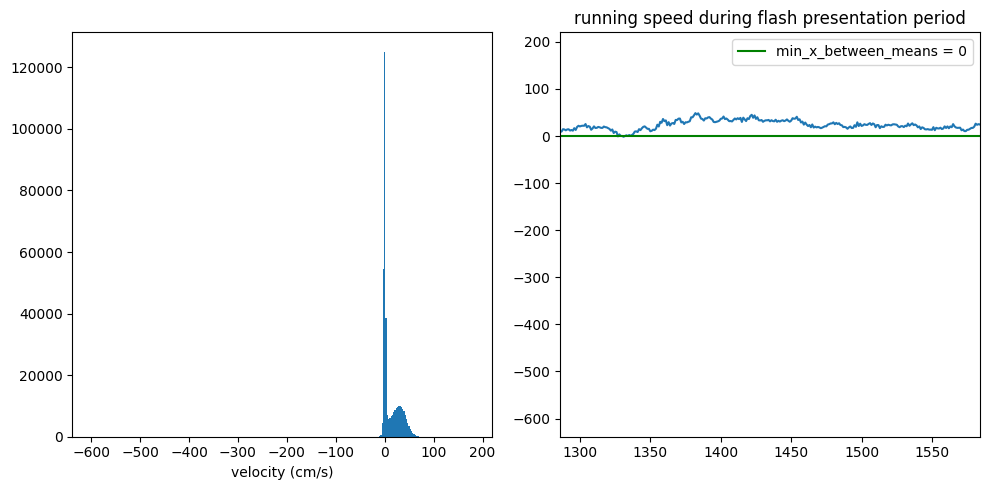

SESSION ID = 750749662
mu1 = 0.03756933360899896
sigma1 = 1.6486388667127927
amplitude1 = 46550.112572656544
mu2 = 22.953731897898102
sigma2 = 16.267139855163755
amplitude2 = 3197.8513495462034

cutoff = 0.27055677548493945
min_x_between_means = 6.551062886579643


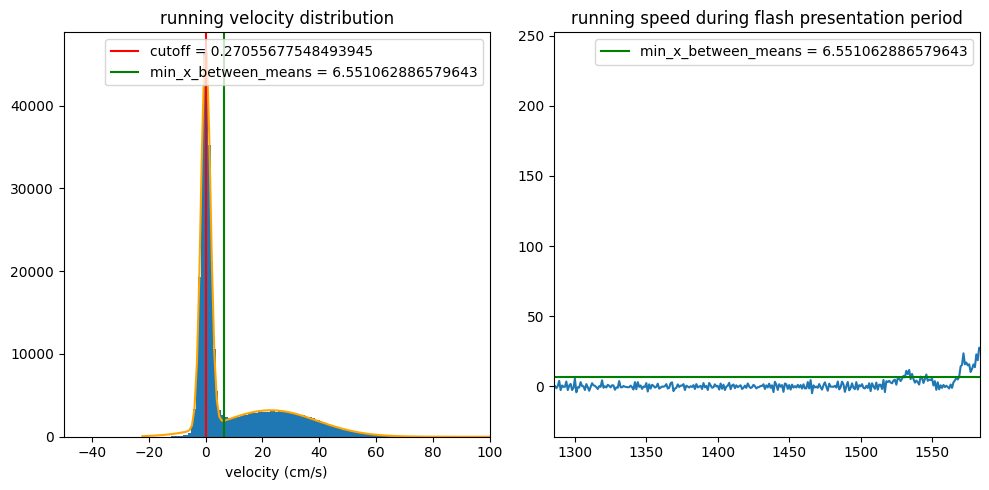

SESSION ID = 760693773
mu1 = 35.65353714222819
sigma1 = 40.74133689356711
amplitude1 = 3401.2515145711423
mu2 = 35.608287076033186
sigma2 = 40.73238056208949
amplitude2 = 3401.5291093395094

cutoff = 35.63090713483223
ERROR IN CALCULATING min_x_between_means


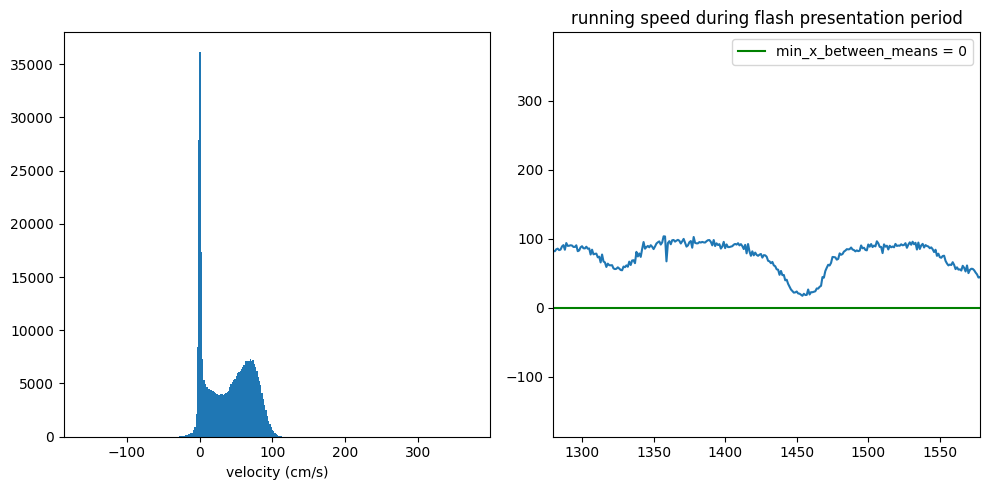

SESSION ID = 758798717
mu1 = 0.30434802897673024
sigma1 = -2.123546324319595
amplitude1 = 75761.98817231064
mu2 = 51.596802680311264
sigma2 = 22.000228697959017
amplitude2 = 15159.19064825883

cutoff = 0.7778208429287005
min_x_between_means = 7.543536232270355


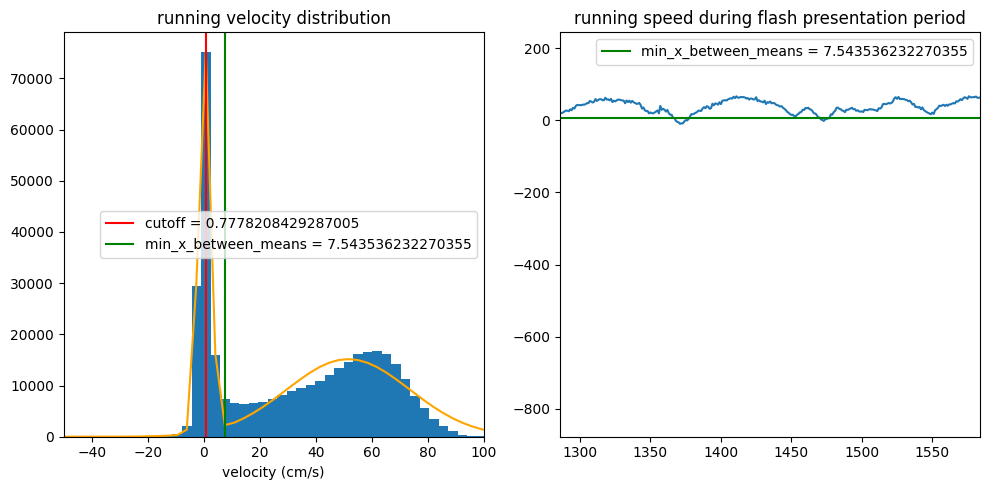

SESSION ID = 791319847
mu1 = 0.037834066012808476
sigma1 = 1.680220471347211
amplitude1 = 56054.65792139316
mu2 = 16.26596985877289
sigma2 = 12.740283089591253
amplitude2 = 5655.466027732033

cutoff = 0.31526461223008745
min_x_between_means = 6.324700255175699


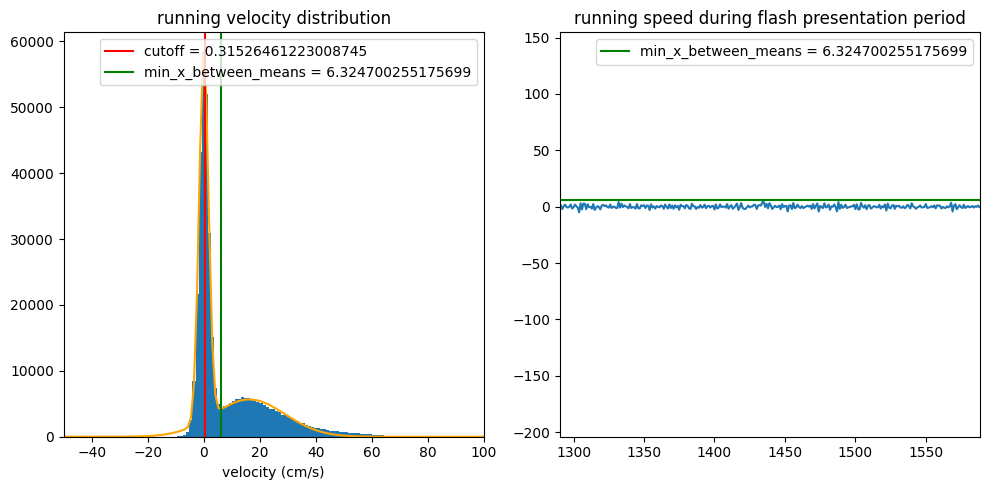

SESSION ID = 797828357
mu1 = 0.026150600787975882
sigma1 = 1.6524663440928593
amplitude1 = 18877.633291318874
mu2 = 5.579074356038135
sigma2 = 6.43754754922573
amplitude2 = 1098.5594632296174

cutoff = 0.36941864032935845
min_x_between_means = 5.476080508204465


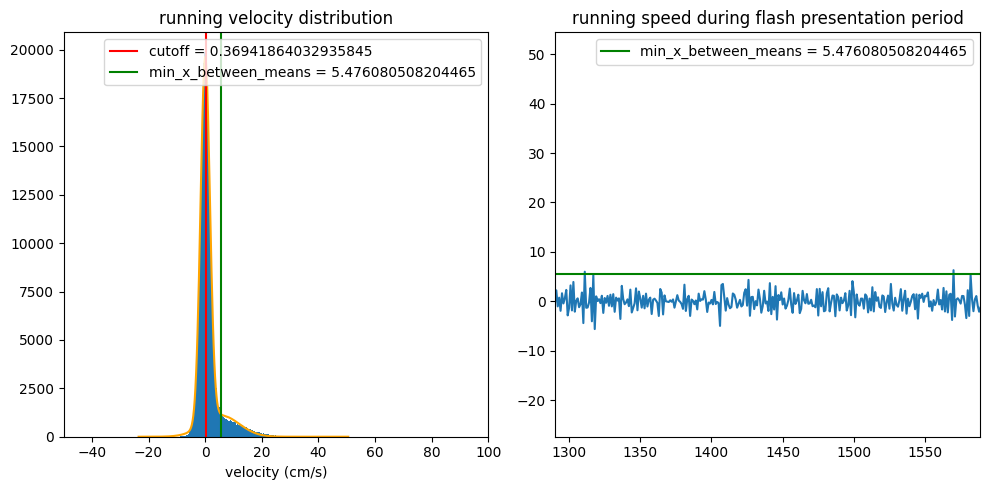

SESSION ID = 760345702
mu1 = 41.87874543476914
sigma1 = 25.52343194214156
amplitude1 = 6088.457375266722
mu2 = 0.0279150715549943
sigma2 = 1.6206042999837023
amplitude2 = 90622.42968081537

cutoff = 0.1959627578242118
ERROR IN CALCULATING min_x_between_means


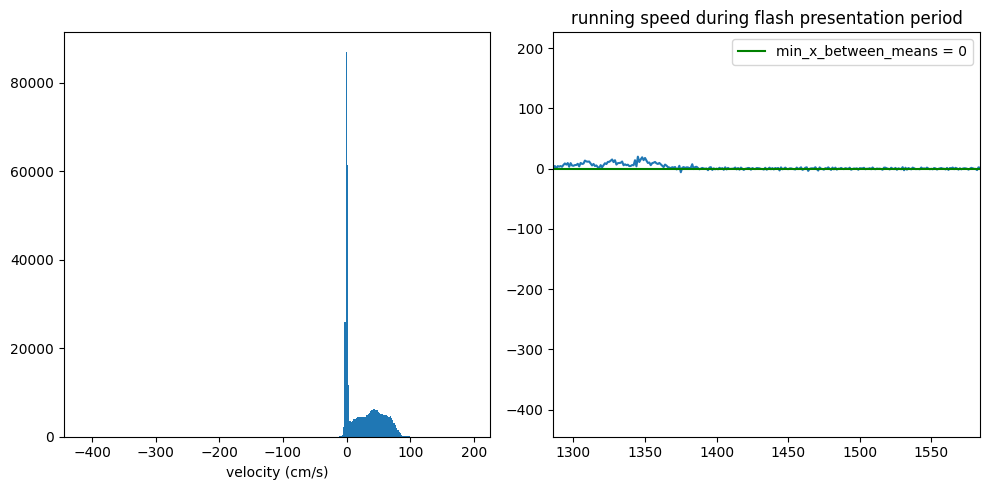

SESSION ID = 715093703
mu1 = 0.05923415232223936
sigma1 = 1.6636899034443913
amplitude1 = 29742.291682435858
mu2 = 14.01142907243082
sigma2 = 8.864624464250435
amplitude2 = 4940.863790630466

cutoff = 0.53394895849592
min_x_between_means = 5.34137221579163


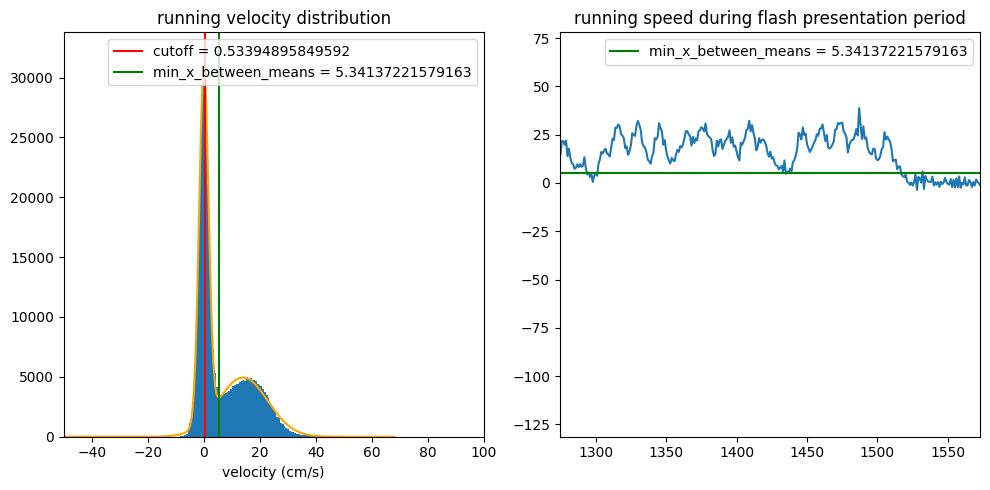

In [22]:
chosen_thresholds = {}
histogram_data = {}
stim_flashes_dfs_dict = {} # for later manual correction

for session_id in existing_sessions:
    min_x_between_means, hist_data, stim_flashes = run(session_id)
    chosen_thresholds[session_id] = min_x_between_means
    histogram_data[session_id] = hist_data
    stim_flashes_dfs_dict[session_id] = stim_flashes

In [23]:
chosen_thresholds

{719161530: 9.564384860472103,
 732592105: 8.013263840973384,
 754312389: 6.1594843907271475,
 750332458: 7.909607857825851,
 751348571: 5.8126045088210105,
 737581020: 0,
 756029989: 0,
 755434585: 0,
 761418226: 0,
 742951821: 0,
 759883607: 0,
 750749662: 6.551062886579643,
 760693773: 0,
 758798717: 7.543536232270355,
 791319847: 6.324700255175699,
 797828357: 5.476080508204465,
 760345702: 0,
 715093703: 5.34137221579163}

### Manual threshold setting

In [42]:
def correct_threshold(session_id, thresh=0, xlim=[-200, 200], bins=300):   
    fig, ax = plt.subplots(ncols=2,nrows=1,figsize=(10,5))
    
    ax[0].hist(histogram_data[session_id],bins=bins)
    ax[0].set_xlabel('velocity (cm/s)')
    ax[0].set_xlim(xlim)
    ax[0].axvline(thresh,c='g',label=f'new threshold = {thresh}')
    ax[0].legend()
    
    ax[1].plot(histogram_data[session_id])
    ax[1].set_xlim([stim_flashes_dfs_dict[session_id].start_time.unique()[0], stim_flashes_dfs_dict[session_id].start_time.unique()[-1]])
    ax[1].set_ylim(xlim)
    ax[1].axhline(thresh,c='g',label=f'new threshold = {thresh}')
    ax[1].legend()
    ax[1].set_xlabel('time (s)')
    ax[1].set_ylabel('velocity (cm/s)')
    
    plt.show()

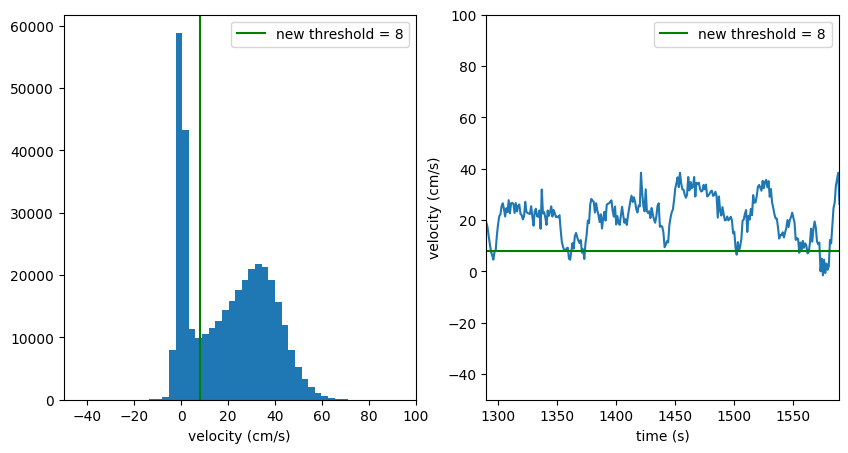

In [43]:
correct_threshold(737581020, xlim=[-50,100], thresh=8)
chosen_thresholds[737581020] = 8

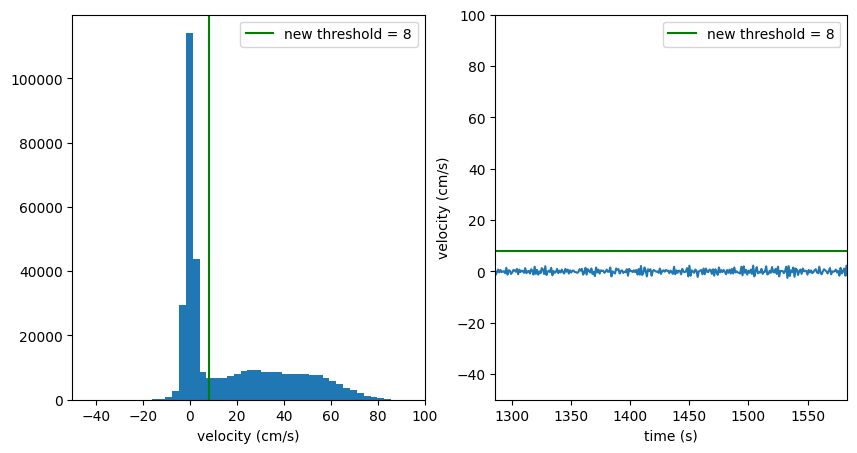

In [44]:
correct_threshold(756029989, xlim=[-50,100], thresh=8)
chosen_thresholds[756029989] = 8

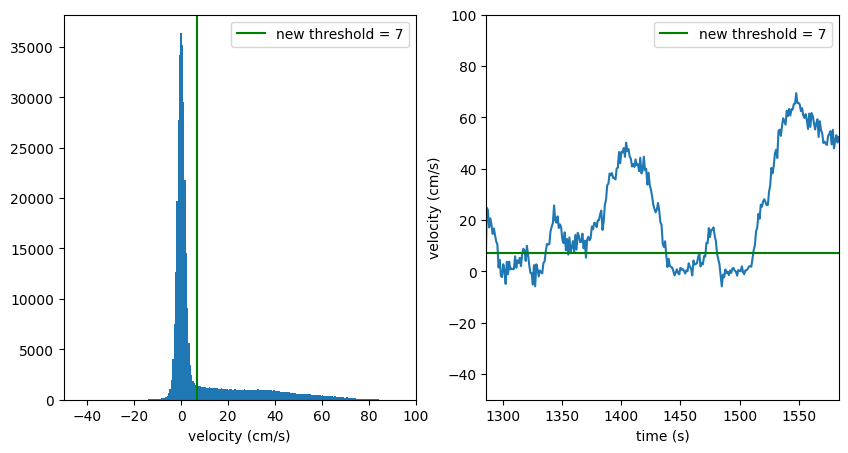

In [45]:
correct_threshold(755434585, xlim=[-50,100], thresh = 7)
chosen_thresholds[755434585] = 7

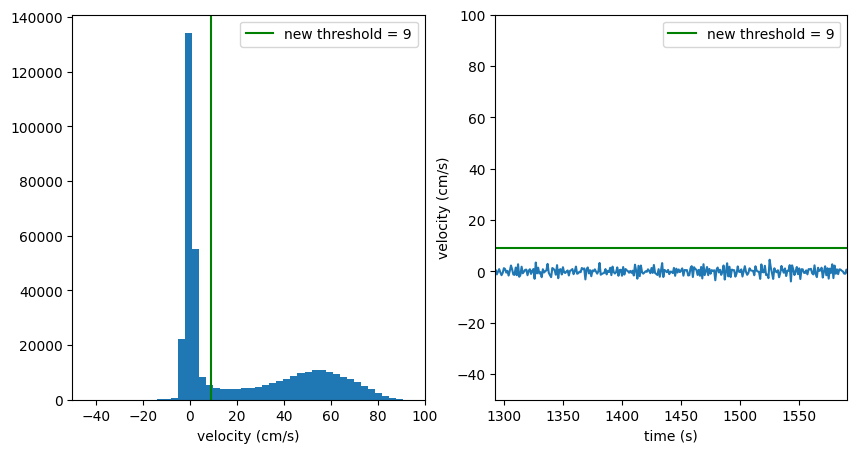

In [46]:
correct_threshold(761418226, xlim=[-50,100], thresh=9)
chosen_thresholds[761418226] = 9

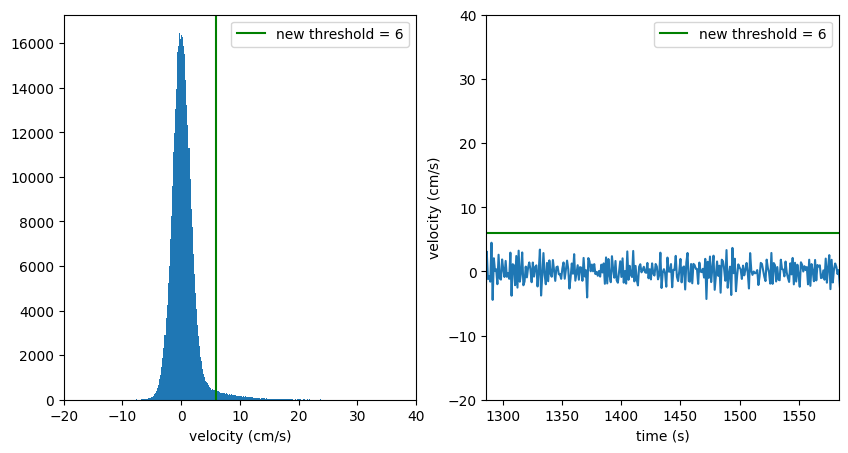

In [51]:
correct_threshold(742951821, xlim=[-20,40], thresh=6)
chosen_thresholds[742951821] = 6

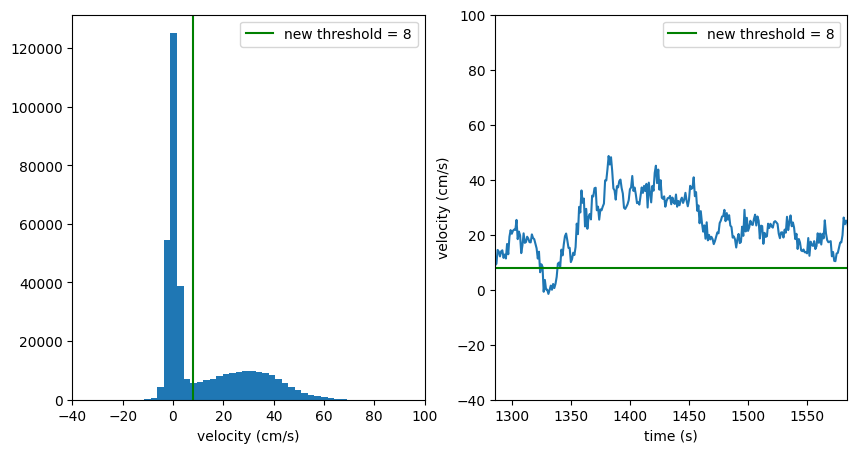

In [56]:
correct_threshold(759883607, xlim=[-40,100], thresh=8)
chosen_thresholds[759883607] = 8

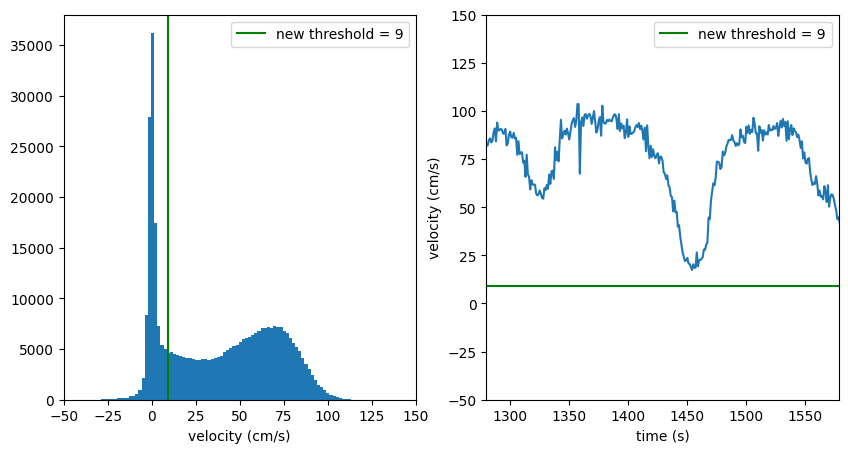

In [62]:
correct_threshold(760693773, xlim=[-50,150], thresh=9)
chosen_thresholds[760693773] = 9

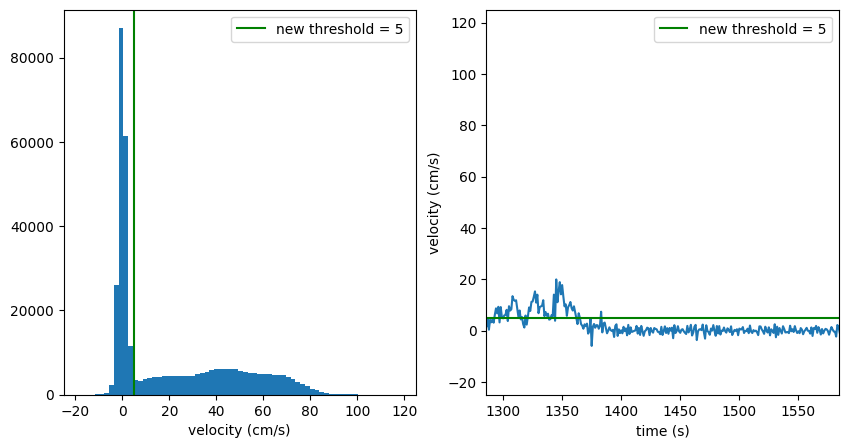

In [74]:
correct_threshold(760345702, xlim=[-25,125], thresh=5)
chosen_thresholds[760345702] = 5

In [75]:
chosen_thresholds

{719161530: 9.564384860472103,
 732592105: 8.013263840973384,
 754312389: 6.1594843907271475,
 750332458: 7.909607857825851,
 751348571: 5.8126045088210105,
 737581020: 8,
 756029989: 8,
 755434585: 7,
 761418226: 9,
 742951821: 6,
 759883607: 8,
 750749662: 6.551062886579643,
 760693773: 9,
 758798717: 7.543536232270355,
 791319847: 6.324700255175699,
 797828357: 5.476080508204465,
 760345702: 5,
 715093703: 5.34137221579163}

In [76]:
with open('chosen_velocity_thresholds.pkl', 'wb') as f:
    pickle.dump(chosen_thresholds, f)